# 3. Model Selection & Regularization

[*This is part 3 of a 6-part tutorial on machine learning in scikit-learn.*]

In this notebook, we'll explore powerful techniques for improving predictions by selecting better models and preventing overfitting through regularization.

## What We've Learned So Far

In previous notebooks, we covered:
1. **Core ML concepts**: Supervised vs. unsupervised learning, regression vs. classification
2. **Overfitting & validation**: Train/test splits, cross-validation, learning curves

Now we face a crucial question: **If we can't easily get more data, how can we still improve our predictions?**

The answer: **Choose better models and regularize them!**

## What You'll Learn in This Notebook

1. **Bias-Variance Tradeoff**: Understanding the fundamental tradeoff in statistical learning
2. **Regularization**: Adding constraints to prevent overfitting
3. **Penalized Regression**: Lasso and Ridge methods that improve on ordinary least squares
4. **Model Tuning**: Using validation curves to find optimal hyperparameters
5. **Beyond Linear Models**: Exploring random forests as a flexible alternative

**Key insight**: Sometimes the best way to improve predictions isn't to get more data—it's to use a better model with the data you already have!

## Setup


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import scale
from sklearn.model_selection import cross_val_score, validation_curve

# Load data
data = pd.read_csv('./data/abide2.tsv', sep='\t')
features = data.filter(like='fs')
y = data['age']

## Bias-Variance Tradeoff

**Bias**: Systematic error from incorrect assumptions
- High bias → underfitting (too simple)
- Low bias → captures complex patterns

**Variance**: Sensitivity to training data fluctuations
- High variance → overfitting (too flexible)
- Low variance → stable predictions

**Key insight**: Reducing variance often requires accepting some bias (and vice versa).

## Regularization

**Regularization** adds constraints to models to prevent overfitting:
- Introduces beneficial bias
- Reduces variance
- Improves generalization

## Penalized Regression

### Ordinary Least Squares (OLS)
$$Cost = \sum_{i=1}^N (y_i - \sum_{j=1}^P \beta_j x_{ij})^2$$

### Lasso Regression (L1 penalty)
$$Cost = \sum_{i=1}^N (y_i - \sum_{j=1}^P \beta_j x_{ij})^2 + \lambda \sum_{j=1}^P |\beta_j|$$

- Shrinks coefficients toward zero
- Sets many coefficients **exactly to zero** → **feature selection**
- Best when few features are truly important

### Ridge Regression (L2 penalty)
$$Cost = \sum_{i=1}^N (y_i - \sum_{j=1}^P \beta_j x_{ij})^2 + \lambda \sum_{j=1}^P \beta_j^2$$

- Shrinks coefficients toward zero
- Never sets coefficients exactly to zero
- Best when many features contribute

**Parameter λ (alpha)**: Controls penalty strength
- λ = 0: no penalty (equivalent to OLS)
- Large λ: strong penalty (more regularization)

## Visualizing Coefficient Paths

In [2]:
# Sample and standardize features
N_FEATURES = 200
X = features.sample(N_FEATURES, axis=1, random_state=99)
X_scaled = scale(X)

# Define helper function to plot coefficient paths
def plot_coef_path(estimator, X, y, alpha_range, title):
    coefs = np.zeros((X.shape[1], len(alpha_range)))
    for i, alpha in enumerate(alpha_range):
        model = estimator(alpha=alpha, max_iter=5000)
        model.fit(X, y)
        coefs[:, i] = model.coef_
    
    plt.figure(figsize=(10, 6))
    plt.plot(alpha_range, coefs.T, alpha=0.7)
    plt.xscale('log')
    plt.xlabel('Penalty (α)', fontsize=12)
    plt.ylabel('Coefficient Value', fontsize=12)
    plt.title(title, fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.show()

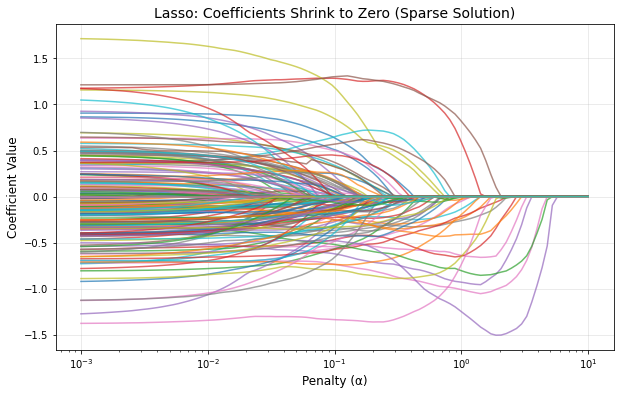

In [3]:
# Lasso coefficient paths
alpha_lasso = np.logspace(-3, 1, 100)
plot_coef_path(Lasso, X_scaled, y, alpha_lasso, 
               'Lasso: Coefficients Shrink to Zero (Sparse Solution)')

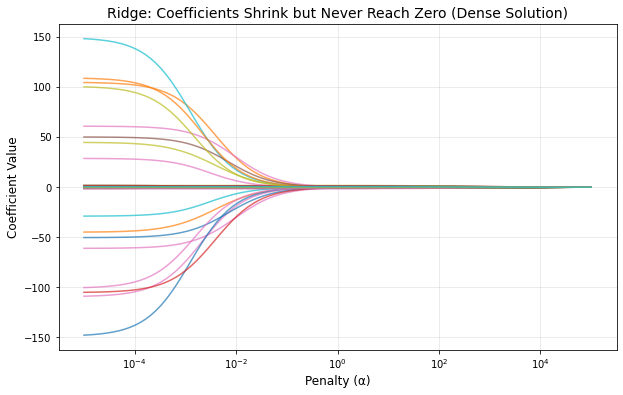

In [4]:
# Ridge coefficient paths
alpha_ridge = np.logspace(-5, 5, 100)
plot_coef_path(Ridge, X_scaled, y, alpha_ridge,
               'Ridge: Coefficients Shrink but Never Reach Zero (Dense Solution)')

## Tuning the Penalty Parameter

How do we choose the optimal penalty? Use **validation curves** to find the α that maximizes test performance.

In [5]:
# Helper function to plot validation curves
def plot_validation_curve(model, X, y, param_range, model_name, baseline_r2=None):
    train_scores, test_scores = validation_curve(
        model, X, y,
        param_name='alpha',
        param_range=param_range,
        cv=5,
        scoring='r2'
    )
    
    train_mean = train_scores.mean(axis=1)
    test_mean = test_scores.mean(axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(param_range, train_mean, 'o-', label='Training', linewidth=2)
    plt.plot(param_range, test_mean, 'o-', label='Test (CV)', linewidth=2)
    
    if baseline_r2 is not None:
        plt.axhline(baseline_r2, linestyle='--', color='gray', 
                    linewidth=2, label='OLS (baseline)')
    
    plt.xscale('log')
    plt.xlabel('Penalty (α)', fontsize=12)
    plt.ylabel('R²', fontsize=12)
    plt.title(f'{model_name} Validation Curve', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1)
    
    # Find optimal alpha
    best_idx = test_mean.argmax()
    best_alpha = param_range[best_idx]
    best_score = test_mean[best_idx]
    
    plt.axvline(best_alpha, linestyle=':', color='red', alpha=0.7)
    plt.text(best_alpha, 0.05, f'Optimal α = {best_alpha:.4f}\nR² = {best_score:.3f}',
             fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.show()
    
    return best_alpha, best_score

OLS baseline R²: 0.567



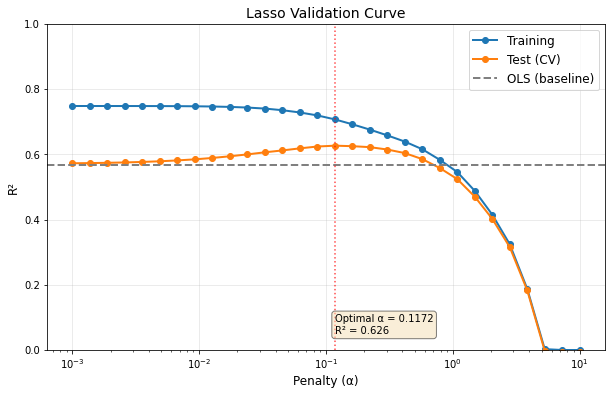


Lasso: Best α = 0.1172, R² = 0.626
Improvement over OLS: 0.059


In [6]:
# Get OLS baseline for comparison
ols_r2 = cross_val_score(LinearRegression(), X_scaled, y, cv=5, scoring='r2').mean()
print(f"OLS baseline R²: {ols_r2:.3f}\n")

# Lasso validation curve
alpha_range_lasso = np.logspace(-3, 1, 30)
best_lasso_alpha, best_lasso_r2 = plot_validation_curve(
    Lasso(max_iter=5000), X_scaled, y, alpha_range_lasso, 'Lasso', ols_r2
)

print(f"\nLasso: Best α = {best_lasso_alpha:.4f}, R² = {best_lasso_r2:.3f}")
print(f"Improvement over OLS: {best_lasso_r2 - ols_r2:.3f}")

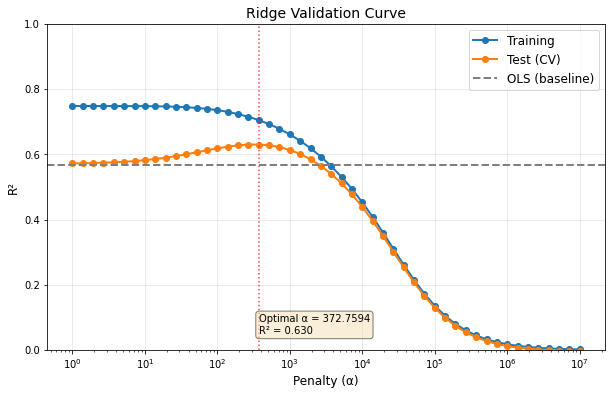


Ridge: Best α = 372.7594, R² = 0.630
Improvement over OLS: 0.063


In [7]:
# Ridge validation curve
alpha_range_ridge = np.logspace(0, 7, 50)
best_ridge_alpha, best_ridge_r2 = plot_validation_curve(
    Ridge(), X_scaled, y, alpha_range_ridge, 'Ridge', ols_r2
)

print(f"\nRidge: Best α = {best_ridge_alpha:.4f}, R² = {best_ridge_r2:.3f}")
print(f"Improvement over OLS: {best_ridge_r2 - ols_r2:.3f}")

## Comparing Models

Let's compare OLS, Lasso, and Ridge using their optimal parameters.

Model  Mean R²   Std R²
  OLS 0.567113 0.021445
Lasso 0.626457 0.010510
Ridge 0.629953 0.014040


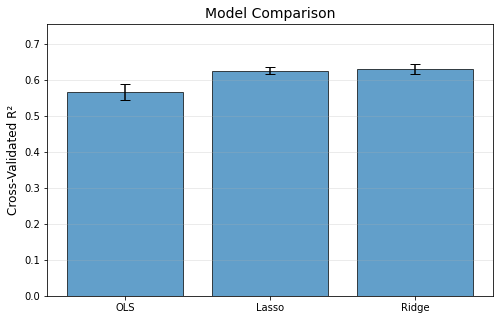

In [8]:
models = [
    ('OLS', LinearRegression()),
    ('Lasso', Lasso(alpha=best_lasso_alpha, max_iter=5000)),
    ('Ridge', Ridge(alpha=best_ridge_alpha))
]

results = []
for name, model in models:
    scores = cross_val_score(model, X_scaled, y, cv=5, scoring='r2')
    results.append({
        'Model': name,
        'Mean R²': scores.mean(),
        'Std R²': scores.std()
    })

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

# Visualize comparison
plt.figure(figsize=(8, 5))
plt.bar(results_df['Model'], results_df['Mean R²'], yerr=results_df['Std R²'],
        capsize=5, alpha=0.7, edgecolor='black')
plt.ylabel('Cross-Validated R²', fontsize=12)
plt.title('Model Comparison', fontsize=14)
plt.ylim(0, max(results_df['Mean R²']) * 1.2)
plt.grid(axis='y', alpha=0.3)
plt.show()

## Summary

**Key Concepts:**

1. **Bias-Variance Tradeoff**: Accept some bias to reduce variance
2. **Regularization**: Add constraints to prevent overfitting
3. **Lasso**: Sparse solutions (feature selection)
4. **Ridge**: Dense solutions (all features contribute)
5. **Validation Curves**: Tune hyperparameters systematically

**Best Practices:**
- Always compare regularized models to OLS baseline
- Use cross-validation to tune penalty parameters
- Try both Lasso and Ridge to see which works better
- More data usually beats fancier algorithms